# **CIS545 Final Project - Employment Outcome Prediction**


Zhanpeng Sun, Kexin Li, Zixuan Geng

## PART 1: Introduction

In this project, we aim to build a classification model to predict whether job applicants has been employed based on their personal background, education, technical skills, and professional experience. The dataset, sourced from Kaggle, contains responses from over 70000 applicants and includes features such as age, education level, gender, coding experience, previous salary, and computer skills.

By leveraging machine learning techniques, our goal is to identify key factors that inluence hiring outcomes and provide data-driven insights into the employability landscape. This can potentially help recruiters and organizations make more informed decisions during the hiring process, while also highlighting the traits most associated with successful employment.

## PART 2: Exploratory Data Analysis

Exploratory Data Analysis was conducted to gain an initial understanding of the dataset's structure, identify potential data quality issues and uncover patterns or relationships among the variables that may inform feature engineering and modeling. We examined the distribution of both catagorical and numerical features, checked for missing or inconsistent values, and visualized correlations to better understand the factors that may influence employability.

First, we loaded the dataset and imported the packages we needed.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# cd /content/drive/MyDrive
# stackoverflow_df = pd.read_csv("/content/drive/MyDrive/stackoverflow_full.csv")
# country_status = pd.read_csv("/content/drive/MyDrive/countries_development_status_fixed.csv")

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import Recall
import shap
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
import optuna
from sklearn.model_selection import cross_val_score

In [ ]:
stackoverflow_df = pd.read_csv("https://raw.githubusercontent.com/GengPangPang/5450Files/refs/heads/main/stackoverflow_full.csv")
country_status = pd.read_csv("https://raw.githubusercontent.com/GengPangPang/5450Files/refs/heads/main/countries_development_status_fixed.csv")

### 2.1 Dataset Overview

The dataset consists of a variety of features capturing demographic, educational, and professional background information of job applications. A brief descriptioin of each column is provided below:


*   Age: Indicates whether the applicant is above or below 35 years old (categorical).
*   Edlevel: The highest education level attained by the applicant (e.g., Undergraduate, Master, PhD)(categorical).
*   Gender: The gender identity of the applicant (e.g., Man, Woman, NonBinary)(categorical).
*   MainBranch: Whether the applicant identifies as a professional developer (categorical).
*   YearsCode: Total years of coding experience, including non-professional contexts (integer).
*   YearsCodePro: Years of coding experience in a professional setting (integer).
*   PreviousSalary: The applicant's previous job salary (float).
*   HaveWorkedWith: The programming languages, tools, or technologies that an applicant has experience working with (categorical).
*   ComputerSkills: Derived from the `HaveWorkedWith`, which lists all known technologies; this variable counts the total number of skills (numerical).
*   Employment: Indicates whether the applicant was currently employed at the time of filling out the application (binary categorical).
*   Employed: Target variable. The outcome variable showing whether the applicant was hired after the application process (binary categorical).

The comlumn `accssibility` and `MentalHealth` contains categorical values, but their meanings are unclear based on the dataset description. Since we were unable to interpret or derive a meaningful relationship with the target variable, we decided to remove these two feature during preprocessing.

Since `ComputerSkills` is derived from `HaveWorkedWith`, and the two features are highly redundant, we decided to retain only `Computerskills` for further analysis and drop the `HaveWorkedWith` column during preprocessing.

And we noticed a column named `Unnamed: 0`, which contains sequential integers starting from 0. This appears to be a leftover index column from the original dataset export and does not carry any meaningful information. As such, we decided to drop this column during data preprocessing.








Here is the information of this dataset.

In [ ]:
stackoverflow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73462 entries, 0 to 73461
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      73462 non-null  int64  
 1   Age             73462 non-null  object 
 2   Accessibility   73462 non-null  object 
 3   EdLevel         73462 non-null  object 
 4   Employment      73462 non-null  int64  
 5   Gender          73462 non-null  object 
 6   MentalHealth    73462 non-null  object 
 7   MainBranch      73462 non-null  object 
 8   YearsCode       73462 non-null  int64  
 9   YearsCodePro    73462 non-null  int64  
 10  Country         73462 non-null  object 
 11  PreviousSalary  73462 non-null  float64
 12  HaveWorkedWith  73399 non-null  object 
 13  ComputerSkills  73462 non-null  int64  
 14  Employed        73462 non-null  int64  
dtypes: float64(1), int64(6), object(8)
memory usage: 8.4+ MB


To preview the structure and formatting of the dataset, we displayed the first five rows below. This allowed us to verify that the data was loaded correctly and provides a quick glimpse into typical entries.

In [ ]:
stackoverflow_df.head()

,Unnamed: 0,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0


### 2.2 Missing Values

To ensure the quality and completeness of the data, we examined the dataset for missing values. Identifying missing entries is an essential part of exploratory data analysis, as they may reduce the effectiveness of machine learning models if not handled properly.

In [ ]:
stackoverflow_df.isnull().sum()

,0
Unnamed: 0,0
Age,0
Accessibility,0
EdLevel,0
Employment,0
Gender,0
MentalHealth,0
MainBranch,0
YearsCode,0
YearsCodePro,0


Upon inspecting the dataset, we found that all columns are fully populated except for `HaveWorkedWith`, which contains 63 missing values out of 73462 entries. This accounts for approximately 0.086% of the dataset, indicating that the overall completeness of the data is very high. Since the proportion of missing data is neligible, we will address this during the data preprocessing stage.

### 2.3 Feature Distributions

Understanding the distribution of the features allows us to identify imbalances, outliers, and skewness in the data, which in turn informs preprocessing decisions. We separate our analysis into categorical and numerical features.

#### 2.3.1 Categorical Features

We first examine several categorical variables using count plots to visualize their distribution.

**EdLevel**

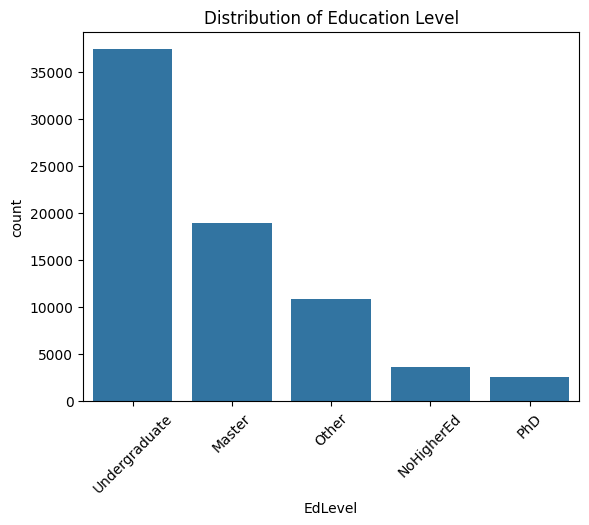

In [ ]:
sns.countplot(data=stackoverflow_df, x="EdLevel", order=stackoverflow_df["EdLevel"].value_counts().index)
plt.title("Distribution of Education Level")
plt.xticks(rotation=45)
plt.show()

Most applicants have an Undergraduate or Master's degree. PhD and NoHigherEd responses are comparatively rare.

**Gender**

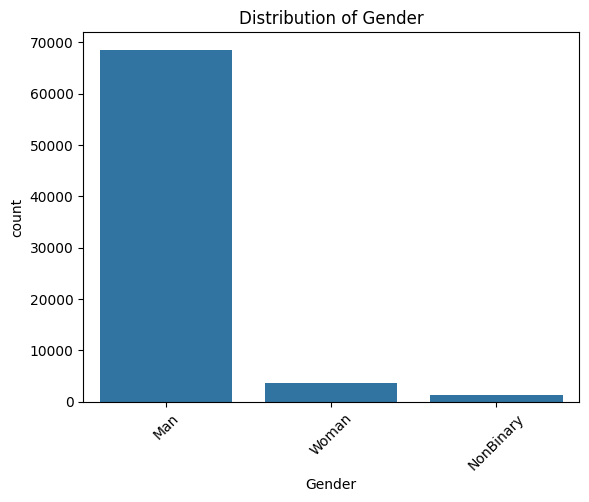

In [ ]:
sns.countplot(data=stackoverflow_df, x="Gender", order=stackoverflow_df["Gender"].value_counts().index)
plt.title("Distribution of Gender")
plt.xticks(rotation=45)
plt.show()


The `Gender` distribution is highly imbalanced, with the majority of applicants identifying as "Man". Female and NonBinary participants make up a very small portion of the dataset, which may introduce bias and should be considered during model evaluation or resampling.

**MainBranch**

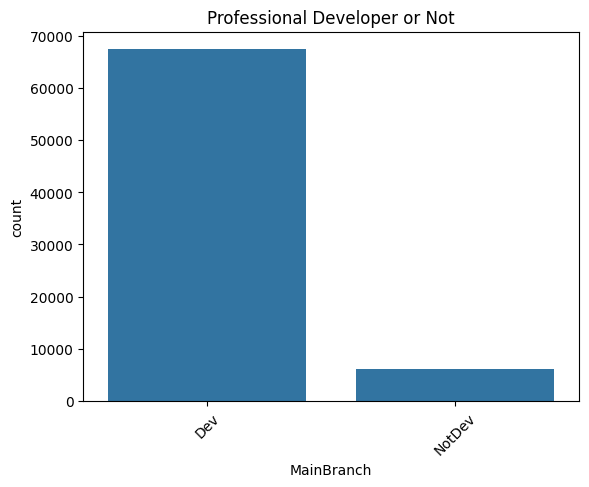

In [ ]:
sns.countplot(data=stackoverflow_df, x="MainBranch", order=stackoverflow_df["MainBranch"].value_counts().index)
plt.title("Professional Developer or Not")
plt.xticks(rotation=45)
plt.show()


Most respondents identify as professional developers, suggesting the dataset is primarily composed of individuals with technical backgrounds.

**Age**

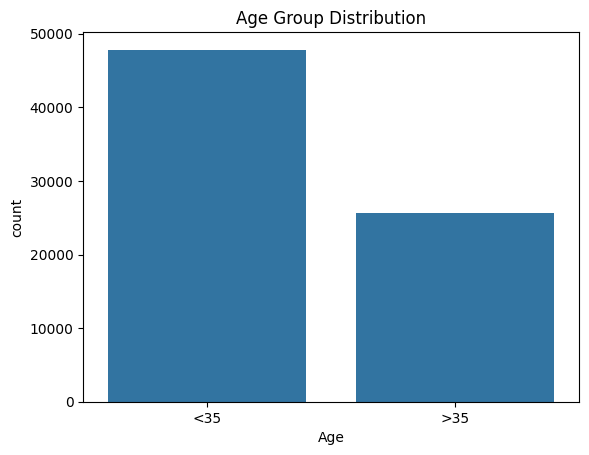

In [ ]:
sns.countplot(data=stackoverflow_df, x="Age", order=stackoverflow_df["Age"].value_counts().index)
plt.title("Age Group Distribution")
plt.show()


The `Age` distribution is skewed toward younger applicants, with a majority under the age of 35. This may reflect the demographic of early-career professionals or recent graduates in the tech industry.

**Country**

In [ ]:
country_counts = stackoverflow_df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

m = folium.Map(location=[20, 0], zoom_start=2, tiles='cartodb positron')

folium.Choropleth(
    geo_data='https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json',
    name='choropleth',
    data=country_counts,
    columns=['Country', 'Count'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Applicant Count by Country'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [ ]:
top_countries = stackoverflow_df["Country"].value_counts().nlargest(10)
df_top_countries = top_countries.reset_index()
df_top_countries.columns = ["Country", "Count"]

fig = px.bar(
    df_top_countries,
    x="Count",
    y="Country",
    orientation='h',
    text="Count",
    title="Top 10 Most Represented Countries",
    color="Count",
    color_continuous_scale='Viridis',
    height=500,
    width=1200
)

fig.update_traces(textposition='outside')
fig.update_layout(yaxis=dict(autorange="reversed"))

fig.show()

Most applicants are from the United States and a few other countries, indicating a strong geographic imbalance that could affect model generalizability.

#### 2.3.2 Numerical Features

We now analyze the distribution of the numerical features in the dataset.

**Employment**

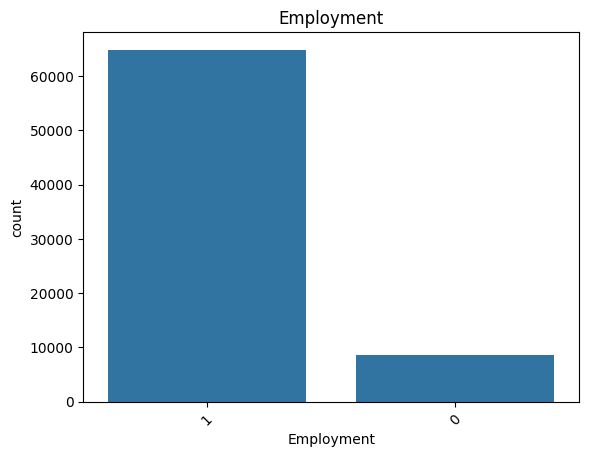

In [ ]:
sns.countplot(data=stackoverflow_df, x="Employment", order=stackoverflow_df["Employment"].value_counts().index)
plt.title("Employment")
plt.xticks(rotation=45)
plt.show()


The `Employment` feature is heavily imbalanced, with most applicants currently employed (1). Only a small portion reported being unemployed (0) at the time of the survey.

**YearsCode & YearsCodePro**

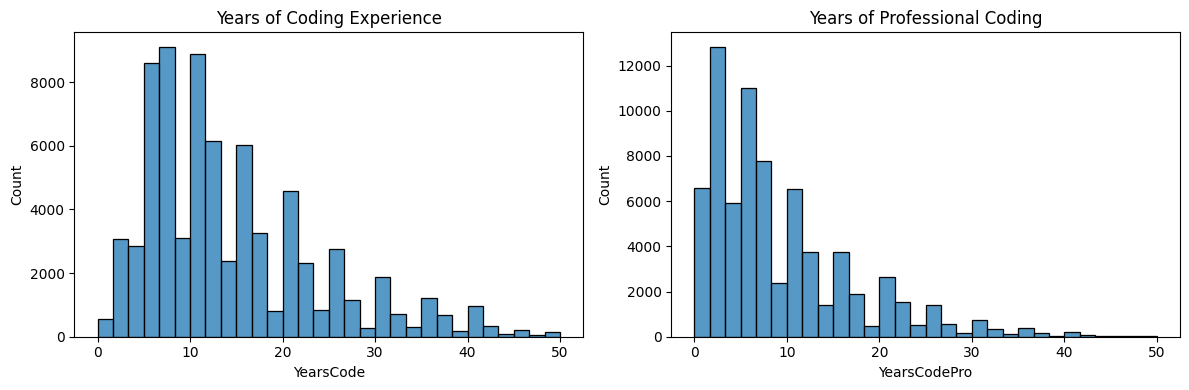

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(stackoverflow_df["YearsCode"], bins=30, ax=axs[0])
axs[0].set_title("Years of Coding Experience")

sns.histplot(stackoverflow_df["YearsCodePro"], bins=30, ax=axs[1])
axs[1].set_title("Years of Professional Coding")

plt.tight_layout()
plt.show()


The distribution of both `YearsCode` and `YearsCodePro` are right-skewed, with most applicants reporting less than 15 years of experience. YearsCodePro is even more concentrated toward lower values, indicating many respondents have limited professional coding background.

**PreviousSalary**

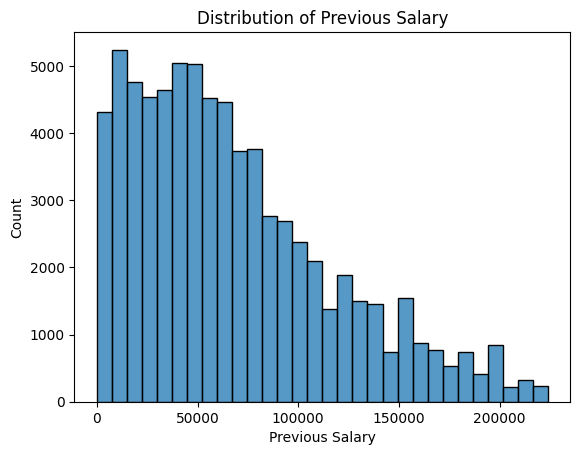

In [ ]:
sns.histplot(stackoverflow_df["PreviousSalary"], bins=30)
plt.title("Distribution of Previous Salary")
plt.xlabel("Previous Salary")
plt.ylabel("Count")
plt.show()


The `PreviousSalary` distribution is highly right-skewed, with most respondents earning below $100000.

**ComputerSkills**

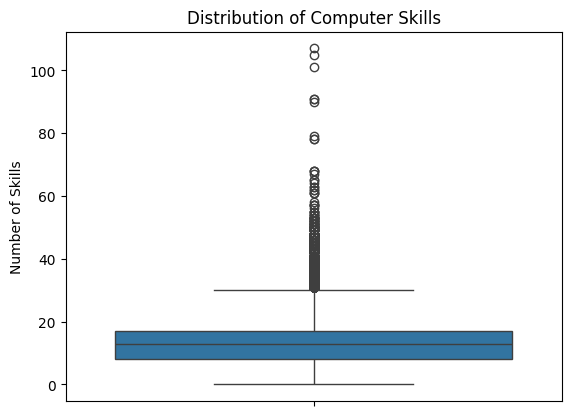

In [ ]:
sns.boxplot(y=stackoverflow_df["ComputerSkills"])
plt.title("Distribution of Computer Skills")
plt.ylabel("Number of Skills")
plt.show()


Most applicants list a moderate number of computer skills, but the feature contains many outliers with unusually high values. These may distort scale-based models and should be addressed during preprocessing.

#### 2.3.3 Summary

From the feature distribution analysis, we observe notable imbalances and skews across multiple variables. Categorical features such as `Gender`, `Mainbranch`, and `Country` show significant class imbalances, while numerical features like `YearsCode`, `PreviousSalary`, and `ComputerSkills` are right-skewed and contain outliers. These findings will inform our data preprocessing decisions, such as encoding stategies, scaling, and outlier treatment, to ensure the model performs reliably across diverse inputs.

### 2.4 Correlation Analysis

To explore relationships between numerical features and identify potential multicollinearity or redundancy, we conducted a correlation analysis. This helps inform feature selection, transformation strategies, and highlights variables that may be useful predictors of employability.

#### 2.4.1 Numerical Features vs Employment Outcome

**Correlation Heatmap**

We computed the Pearson correlation coefficients among the numerical variables.

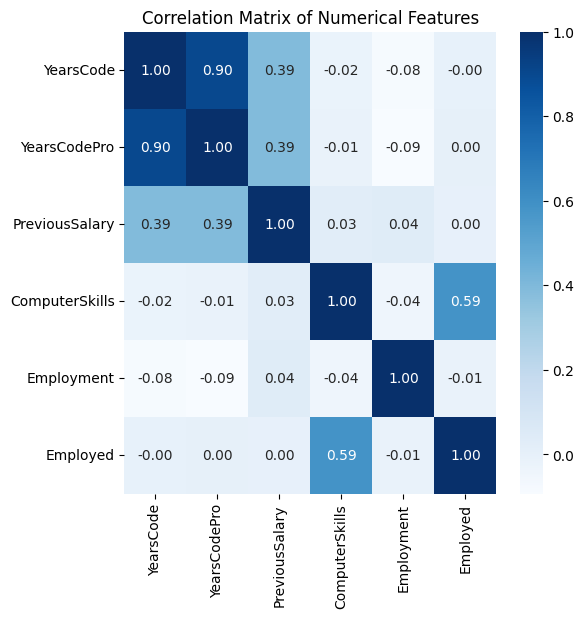

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ["YearsCode", "YearsCodePro", "PreviousSalary", "ComputerSkills", "Employment", "Employed"]
corr_matrix = stackoverflow_df[numeric_cols].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


**Observations:**
*   `YearsCode` and `YearsCodePro` show a strong positive correlation (0.90), as expected, since professional experience is generally part of total experience. One of them might be redundant.
*   `ComputerSkills` and `Employed` show a moderate positive correlation (0.59), suggesting that having  more technical skills increases the likelihood of being hired.
*   Other features like `YearsCode`, `YearsCodePro`, and `PreviousSalary` show very weak or near-zero correlation with `Employed`, indicating limited predictive power in isolation.
*   Surprisingly, `Employment` (current job status) is nearly uncorrelated with `Employed` (hiring outcome), with a coefficient close to 0.
*   No pairs (other than `YearsCode` & `YearsCodePro` show concerningly high correlation (e.g., >0.95), so multicollinearity is not a major concern.





#### 2.4.2 Categorical Features vs Employment Outcome

To better understand how different categorical variables influence the likelihood of being hired, we examined the relationship between each categorical feature and the binary target variable `Employed`. Specifically, we used bar plots to visualize the proportion of applicants hired (`Employed` = 1) within each category.

**Gender vs Employed**

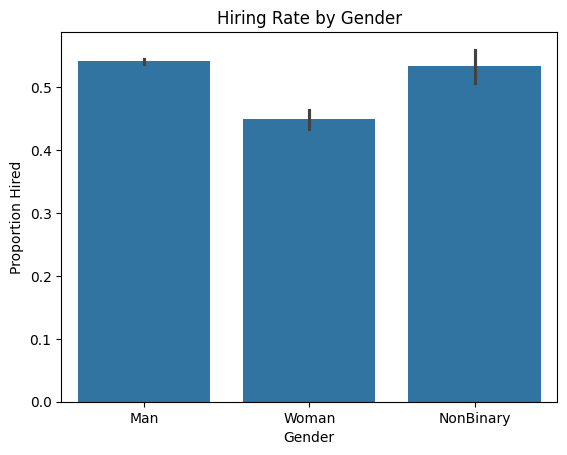

In [ ]:
sns.barplot(x="Gender", y="Employed", data=stackoverflow_df)
plt.title("Hiring Rate by Gender")
plt.ylabel("Proportion Hired")
plt.show()


The plot reveals that male and non-binary applicants have higher hiring rate (around 53%) compared to female applicants (approximately 45%). This suggests a potential gender disparity in employment outcomes within the dataset.

**Age vs Employed**

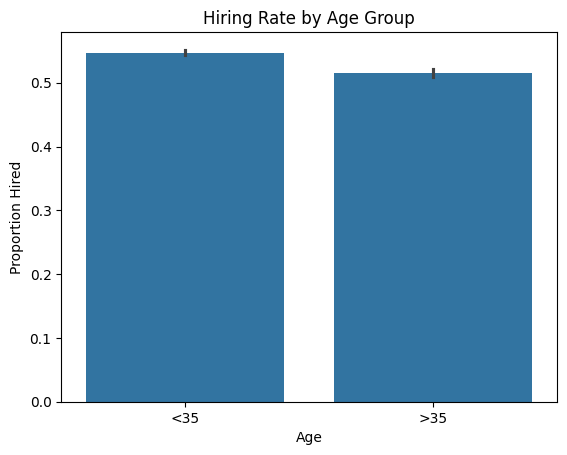

In [ ]:
sns.barplot(x="Age", y="Employed", data=stackoverflow_df)
plt.title("Hiring Rate by Age Group")
plt.ylabel("Proportion Hired")
plt.show()


This plot shows that applicants under 35 have a slightly higher hiring rate compared to those over 35. However, the difference is relatively small, suggesting age may not be a strong predictor of employment outcome in this dataset.

**MainBranch vs Employment**

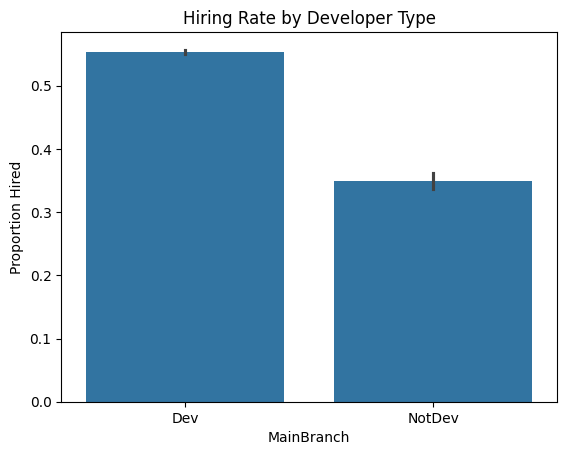

In [ ]:
sns.barplot(x="MainBranch", y="Employed", data=stackoverflow_df)
plt.title("Hiring Rate by Developer Type")
plt.ylabel("Proportion Hired")
plt.show()


The plot indicates that individuals who identify as professional developers have a significantly higher hiring rate compared to those who do not, suggesting that professional experience may be a strong factor in employment outcomes.

**EdLevel vs Employed**

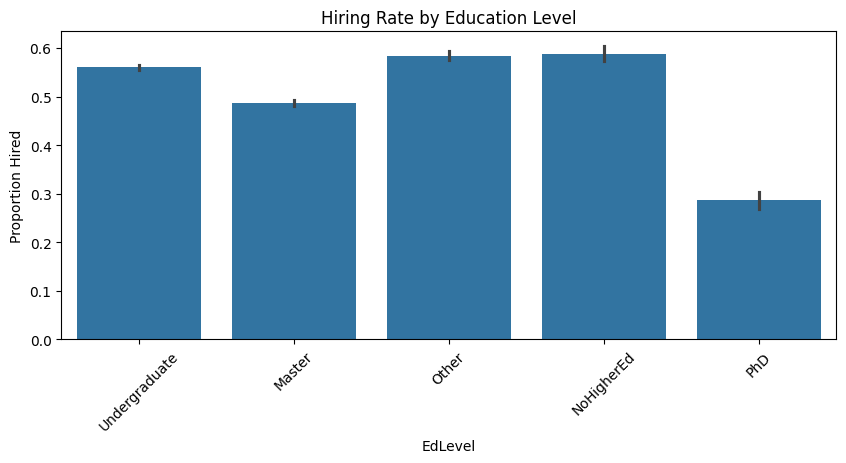

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(x="EdLevel", y="Employed", data=stackoverflow_df, order=stackoverflow_df["EdLevel"].value_counts().index)
plt.title("Hiring Rate by Education Level")
plt.ylabel("Proportion Hired")
plt.xticks(rotation=45)
plt.show()


The plot reveals that applicants with a PhD have the lowest hiring rate among all education levels, while those with "Other" or "NoHigherEd" backgrounds exhibit the highest rates. This countertuitive trend suggests that factors beyond formal education may significantly inluence employability.

## PART 3: Data Pre-processing and Feature Engineering

To prepare the dataset for modeling, we performed a series of preprocessing and feature engineering steps to ensure data quality and improve model performance.

### 3.1 Column Removal

To clean up the dataset, we first removed columns that were either redundant or not useful. The `Unnamed: 0` column is an index artifact from the CSV export and hold no analytical values. The `Accessibility` and `MentalHealth` columns contains categorical values, but their meanings are unclear from the dataset description. Since we could not confidently interpret its meaning or relevance to employment outcomes, we removed them.

The `HaveWorkedWith` column lists technologies and tools each applicant has used, but this information is already captured numerically in the `ComputerSkills` column. To avoid redundancy, we removed `HaveWorkedWith` and retained `ComputerSkills`.

In addition, the columns `YearsCode` and `YearsCodePro`--representing total and professional coding experience--are highly correlated (correlation = 0.90). To reduce multicollinearity and simplify the feature set. we retained only `YearsCodePro`, which more directly reflects professional experience.




In [ ]:
columns_to_drop = ["Unnamed: 0", "Accessibility", "HaveWorkedWith", "YearsCode", "MentalHealth"]
stackoverflow_cleaned_df = stackoverflow_df.drop(columns=columns_to_drop)

### 3.2 Handling Missing Values

The dataset is nearly complete, with only 63 missing values in the `HaveWorkedWith` column, which has already been removed. Therefore, no further imputation or removal of data was necessary.

### 3.3 Encoding Categorical Variables

Before encoding, we first conducted data cleaning and restructuring of categorical variables to ensure efficient and meaningful feature representation.

**Country Feature Transformation**  
Initially, the `Country` column contained a wide range of country names, making direct one-hot encoding impractical due to the large number of categories and resulting dimensionality.  
To address this, we visualized the distribution of applicant countries using **Folium**, and found that countries could be more meaningfully grouped by development level (e.g., **Developed** vs. **Developing**).  
We therefore replaced the raw country names by merging with a reference table containing each country's development status, resulting in a binary feature called `Country_Development_Status`.  
This reduced sparsity and improved interpretability, while still preserving relevant geographical context.

**Education Feature Cleaning**  
We also removed rows where `EdLevel` was labeled as `"Other"` to maintain a consistent order during ordinal encoding. This ensured the feature could be numerically encoded in a meaningful and ordered way.

**Encoding Strategy**  
We then encoded the remaining categorical variables using the following strategy:

- **Binary categorical features** (e.g., `Employment`, `MainBranch`) were one-hot encoded using `drop='first'` to avoid multicollinearity.
- **Multi-class categorical features** such as `Gender` were one-hot encoded as well, with unknown categories handled gracefully.
- **Education level** was encoded using **ordinal encoding**, where the logical hierarchy was preserved:  
  `"NoHigherEd"` < `"Undergraduate"` < `"Master"` < `"PhD"`.

All encoded features were combined into a new DataFrame called `final_df`, which served as the clean, fully numeric input for downstream modeling. A copy (`final_test`) was also made for use in hypothesis testing.


In [ ]:
# # Step 1: Combine rare countries into 'other'
# country_counts = stackoverflow_cleaned_df["Country"].value_counts()
# valid_countries = country_counts[country_counts > 50].index
# stackoverflow_cleaned_df["Country"] = stackoverflow_cleaned_df["Country"].where(
#     stackoverflow_cleaned_df["Country"].isin(valid_countries), other="other"
# )
#Step 1: Indentify the country status(developed or developing)
stackoverflow_cleaned_df = pd.merge(stackoverflow_cleaned_df, country_status, how='left', on='Country')
stackoverflow_cleaned_df = stackoverflow_cleaned_df.drop(columns=["Country","Standardized Country"])
stackoverflow_cleaned_df.rename(columns={'Development Status': 'Country_Development_Status'}, inplace=True)

# Step 2: Remove rows with ambiguous education level
stackoverflow_cleaned_df = stackoverflow_cleaned_df[
    stackoverflow_cleaned_df["EdLevel"] != "Other"
].reset_index(drop=True)

# Step 3: Categorical Encoding

# 3.1 Identify categorical columns
categorical_features = sorted(stackoverflow_cleaned_df.select_dtypes(include=["object"]).columns.tolist())
stackoverflow_categorical_df = stackoverflow_cleaned_df[categorical_features]

# 3.2 Identify binary categorical columns
binary_col_names = stackoverflow_categorical_df.nunique() == 2
binary_col_names = stackoverflow_categorical_df.columns[binary_col_names]
stackoverflow_binary_df = stackoverflow_categorical_df[binary_col_names]

# 3.3 Encode binary categorical columns
binary_encoder = OneHotEncoder(sparse_output=False, drop='first', dtype=float)
encoded_binary = binary_encoder.fit_transform(stackoverflow_binary_df)
binary_encoded_df = pd.DataFrame(encoded_binary, columns=binary_col_names, index=stackoverflow_cleaned_df.index)

# 3.4 Concatenate binary-encoded columns back
df_step2 = pd.concat([stackoverflow_cleaned_df.drop(columns=binary_col_names), binary_encoded_df], axis=1)

# 3.5 Encode multi-class categorical features: Gender, Country
multi_val_cols = df_step2[['Gender']]
multi_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
multi_encoded = multi_encoder.fit_transform(multi_val_cols)
multi_encoded_cols = multi_encoder.get_feature_names_out(['Gender'])
multi_encoded_df = pd.DataFrame(multi_encoded, columns=multi_encoded_cols, index=df_step2.index)

df_step3 = pd.concat([df_step2.drop(columns=['Gender']), multi_encoded_df], axis=1)

# 3.6 Ordinal encode EdLevel
edu_order = [["NoHigherEd", "Undergraduate", "Master", "PhD"]]
ordinal_encoder = OrdinalEncoder(categories=edu_order)
df_step3["Education_encoded"] = ordinal_encoder.fit_transform(df_step3[["EdLevel"]])
df_step3 = df_step3.drop(columns=["EdLevel"])

# Final cleaned dataset
final_df = df_step3
final_test = final_df.copy() # For Hypothesis Testing
final_test = final_test[[col for col in final_df.columns if col != 'Employed'] + ['Employed']]

In [ ]:
final_df.head()

,Employment,YearsCodePro,PreviousSalary,ComputerSkills,Employed,Age,Country_Development_Status,MainBranch,Gender_Man,Gender_NonBinary,Gender_Woman,Education_encoded
0,1,4,51552.0,4,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
1,1,5,46482.0,12,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,6,77290.0,7,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,1,6,46135.0,13,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,30,160932.0,2,0,1.0,0.0,1.0,1.0,0.0,0.0,3.0


### 3.4 Normalization of Numerical Features

We standardized all numerical features to ensure they are on a comparable scale. This is especially important for models sensitive to feature magnitude. The features normalized include `YearsCodePro`, `PreviousSalary`, and  `ComputerSkills`.

In [ ]:
# Step 1: Drop the target column
scaling_columns_df = final_df.drop(columns=["Employed"])

# Step 2: Select only truly continuous numerical features (not one-hot)
# Keep columns with more than 2 unique values
numerical_features = [
    col for col in scaling_columns_df.select_dtypes(include=["number"]).columns
    if final_df[col].nunique() > 2
]

# Step 3: Add ordered features
ordered_features = ["Education_encoded"]
features_need_to_scale = list(set(numerical_features + ordered_features))

#Step 4: Train-Test Split
seed = 42
x = final_df.drop(columns=["Employed"])
y = final_df[["Employed"]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=y)

# Step 5: Standardize
scaler = StandardScaler()
x_train[features_need_to_scale] = scaler.fit_transform(x_train[features_need_to_scale])
x_test[features_need_to_scale] = scaler.transform(x_test[features_need_to_scale])

#Step 6: Standardize for final_df
scaler_1 = StandardScaler()
final_df[features_need_to_scale] = scaler_1.fit_transform(final_df[features_need_to_scale])


After these steps, we obtained a clean, fully numeric dataset ready for model training and evaluation in the following section. Below is a preview of the final dataset:

In [ ]:
print(x_train[features_need_to_scale].describe())

       ComputerSkills  Education_encoded  YearsCodePro  PreviousSalary
count    5.009500e+04       5.009500e+04  5.009500e+04    5.009500e+04
mean     5.691292e-17      -7.786964e-17 -5.602643e-18   -9.063515e-17
std      1.000010e+00       1.000010e+00  1.000010e+00    1.000010e+00
min     -1.901878e+00      -2.043136e+00 -1.148157e+00   -1.381565e+00
25%     -7.553489e-01      -5.020549e-01 -7.612138e-01   -7.798534e-01
50%     -1.820841e-01      -5.020549e-01 -3.742705e-01   -1.999055e-01
75%      5.344969e-01       1.039026e+00  3.996161e-01    5.697679e-01
max      1.343295e+01       2.580107e+00  5.300898e+00    3.136650e+00


In [ ]:
print(final_df.dtypes)

Employment                      int64
YearsCodePro                  float64
PreviousSalary                float64
ComputerSkills                float64
Employed                        int64
Age                           float64
Country_Development_Status    float64
MainBranch                    float64
Gender_Man                    float64
Gender_NonBinary              float64
Gender_Woman                  float64
Education_encoded             float64
dtype: object


## PART 4: Hypothesis Testing

In [ ]:
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from sklearn.metrics import r2_score
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression

### 4.1 The "35-Year-Old Crisis" Hypothesis

**Research Question:**  
Is there a significant relationship between applicant's age group (over 35 vs under 35) and their employment outcome (whether the applicant was hired)?

**Hypotheses:**
- **H₀**: `Age` and `Employed` are independent.
- **H₁**: `Age` and `Employed` are associated.


Observed difference in hiring outcome: 0.0314
Permutation p-value: 0.0000


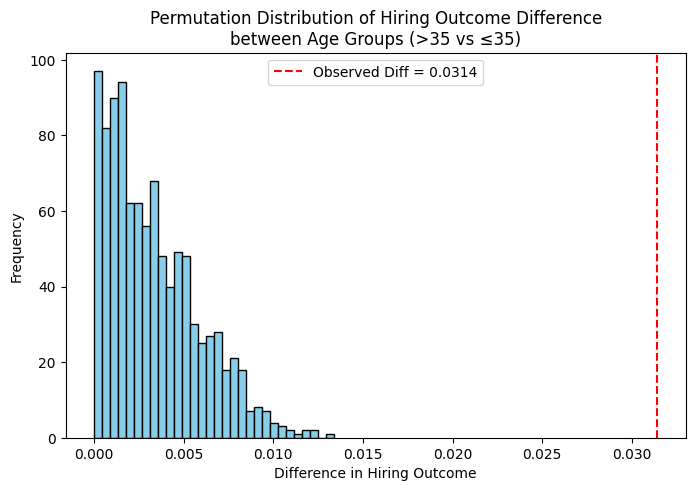

Conclusion: Reject H₀. Age group and hiring outcome are significantly associated.


In [ ]:
# Step 1: Extract relevant columns
age_col = final_df['Age'].values
employed_col = final_df['Employed'].values

# Step 2: Observed difference
observed_diff = abs(final_df.groupby('Age')['Employed'].mean()[1.0] -
                    final_df.groupby('Age')['Employed'].mean()[0.0])
print(f"Observed difference in hiring outcome: {observed_diff:.4f}")

# Step 3: Permutation test
n_permutations = 1000
permuted_diffs = []

for _ in range(n_permutations):
    shuffled = np.random.permutation(employed_col)
    temp_df = pd.DataFrame({'Age': age_col, 'Employed': shuffled})
    diff = abs(temp_df.groupby('Age')['Employed'].mean()[1.0] -
               temp_df.groupby('Age')['Employed'].mean()[0.0])
    permuted_diffs.append(diff)

# Step 4: Calculate p-value
permuted_diffs = np.array(permuted_diffs)
p_value = np.mean(permuted_diffs >= observed_diff)
print(f"Permutation p-value: {p_value:.4f}")

# Step 5: Visualization
plt.figure(figsize=(8, 5))
plt.hist(permuted_diffs, bins=30, color='skyblue', edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='--', label=f'Observed Diff = {observed_diff:.4f}')
plt.title('Permutation Distribution of Hiring Outcome Difference\nbetween Age Groups (>35 vs ≤35)')
plt.xlabel('Difference in Hiring Outcome')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Step 6: Conclusion
alpha = 0.05
if p_value < alpha:
    print("Conclusion: Reject H₀. Age group and hiring outcome are significantly associated.")
else:
    print("Conclusion: Fail to reject H₀. No significant association detected.")


### 4.2 The Gender-Hiring Hypothesis

**Research Question:**  
Is there a significant difference in hiring outcomes between male and non-male applicants?

**Hypotheses:**
- **H₀**: `Gender_Man` and `Employed` are independent.
- **H₁**: `Gender_Man` and `Employed` are associated.


Observed difference in hiring outcome: 0.0707
Permutation p-value: 0.0000


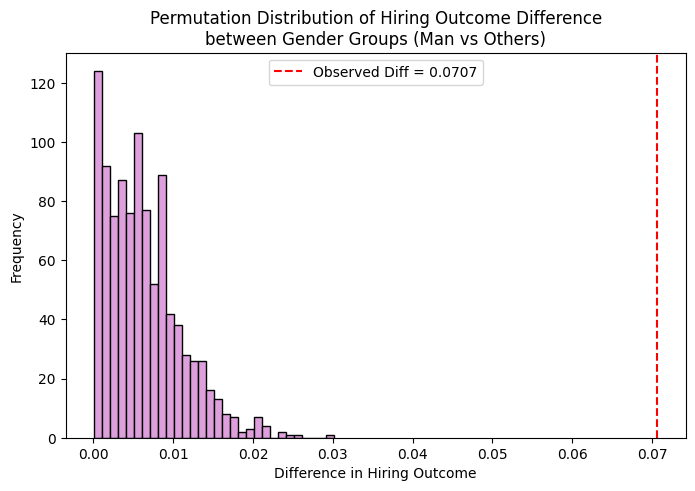

Conclusion: Reject H₀. Gender is significantly associated with hiring outcome.


In [ ]:
# Step 1: Extract relevant columns
gender_col = final_df['Gender_Man'].values

# Step 2: Observed difference
group_means = final_df.groupby('Gender_Man')['Employed'].mean()
observed_diff = abs(group_means[1.0] - group_means[0.0])
print(f"Observed difference in hiring outcome: {observed_diff:.4f}")

# Step 3: Permutation test
permuted_diffs = []

for _ in range(n_permutations):
    shuffled = np.random.permutation(employed_col)
    temp_df = pd.DataFrame({'Gender_Man': gender_col, 'Employed': shuffled})
    diff = abs(temp_df.groupby('Gender_Man')['Employed'].mean()[1.0] -
               temp_df.groupby('Gender_Man')['Employed'].mean()[0.0])
    permuted_diffs.append(diff)

# Step 4: Calculate p-value
permuted_diffs = np.array(permuted_diffs)
p_value = np.mean(permuted_diffs >= observed_diff)
print(f"Permutation p-value: {p_value:.4f}")

# Step 5: Visualization
plt.figure(figsize=(8, 5))
plt.hist(permuted_diffs, bins=30, color='plum', edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='--', label=f'Observed Diff = {observed_diff:.4f}')
plt.title('Permutation Distribution of Hiring Outcome Difference\nbetween Gender Groups (Man vs Others)')
plt.xlabel('Difference in Hiring Outcome')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Step 6: Conclusion
if p_value < alpha:
    print("Conclusion: Reject H₀. Gender is significantly associated with hiring outcome.")
else:
    print("Conclusion: Fail to reject H₀. No significant association detected.")

### 4.3 The Education-Hiring Hypothesis

**Research Question:**  
Does education level significantly affect hiring outcome?

**Hypotheses:**
- **H₀**: `Education_encoded` and `Employed` are independent.
- **H₁**: `Education_encoded` and `Employed` are associated..


In [ ]:
# Step 1: Prepare data
X = sm.add_constant(final_df[['Education_encoded']])
y = final_df['Employed']

# Step 2: Logistic regression
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Step 3: Output results
print(result.summary())

# Step 4: Conclusion
p_value = result.pvalues['Education_encoded']
print(f"\nP-value for Education_encoded: {p_value:.4f}")

if p_value < alpha:
    print("Conclusion: Reject H₀. Education level is significantly associated with hiring outcome.")
else:
    print("Conclusion: Fail to reject H₀. No significant association detected.")


Optimization terminated successfully.
         Current function value: 0.685263
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               Employed   No. Observations:                62619
Model:                          Logit   Df Residuals:                    62617
Method:                           MLE   Df Model:                            1
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:                0.009151
Time:                        23:19:53   Log-Likelihood:                -42911.
converged:                       True   LL-Null:                       -43307.
Covariance Type:            nonrobust   LLR p-value:                2.150e-174
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1126      0.008     13.975      0.000       0.097       0.128
Educatio

### 4.4 The Previous Salary-Hiring Hypothesis

**Research Question:**  
Does previous salary significantly affect hiring outcome?

**Hypotheses:**
- **H₀**: `PreviousSalary` and `Employed` are independent.
- **H₁**: `PreviousSalary` and `Employed` are associated..


In [ ]:
# Step 1: Prepare data
X = sm.add_constant(final_df[['PreviousSalary']])
y = final_df['Employed']

# Step 2: Logistic regression
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Step 3: Output results
print(result.summary())

# Step 4: Conclusion
p_value = result.pvalues['PreviousSalary']
print(f"\nP-value for PreviousSalary: {p_value:.4f}")

if p_value < alpha:
    print("Conclusion: Reject H₀. Previous salary is significantly associated with hiring outcome.")
else:
    print("Conclusion: Fail to reject H₀. No significant association detected.")

Optimization terminated successfully.
         Current function value: 0.691587
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:               Employed   No. Observations:                62619
Model:                          Logit   Df Residuals:                    62617
Method:                           MLE   Df Model:                            1
Date:                Tue, 29 Apr 2025   Pseudo R-squ.:               8.017e-06
Time:                        23:19:53   Log-Likelihood:                -43306.
converged:                       True   LL-Null:                       -43307.
Covariance Type:            nonrobust   LLR p-value:                    0.4047
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1116      0.008     13.944      0.000       0.096       0.127
PreviousSalary   

### 4.5 The Developer Status-Hiring Hypothesis

**Research Question:**  
Is being a professional developer associated with the applicant's hiring outcome?

**Hypotheses:**
- **H₀**: `MainBranch` and `Employed` are independent.
- **H₁**: `MainBranch` and `Employed` are associated.


In [ ]:
# Step 1: Create contingency table
contingency_table = pd.crosstab(final_test['MainBranch'], final_test['Employed'])

# Step 2: Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Step 3: Output results
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.4f}")

# Step 4: Conclusion
if p < alpha:
    print("Conclusion: Reject H₀. Developer status is significantly associated with hiring outcome.")
else:
    print("Conclusion: Fail to reject H₀. No significant association detected.")

Chi-square statistic: 833.4724
Degrees of freedom: 1
p-value: 0.0000
Conclusion: Reject H₀. Developer status is significantly associated with hiring outcome.


### 4.6 The Additional Predictive Value of Core Features

**Research Question:**  
For each feature among YearsCodePro, PreviousSalary, Education Level, and Computer Skills, does it provide additional predictive power for hiring outcome beyond the other three features?

**Hypotheses (for each feature):**
- **H₀**: The feature does not provide additional predictive power beyond the other features.
- **H₁**: The feature provides significant additional predictive power.



Testing additional predictive power of: YearsCodePro
Observed R²: 0.3515
Permutation p-value: 0.3800
Conclusion: Fail to reject H₀. No significant additional contribution from YearsCodePro detected.


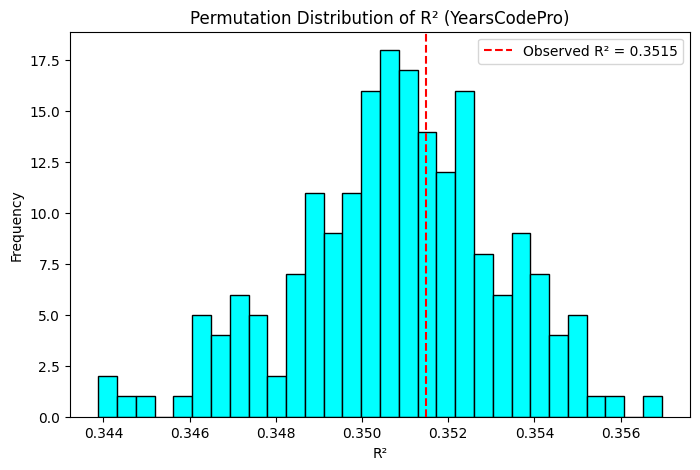

Testing additional predictive power of: PreviousSalary
Observed R²: 0.3515
Permutation p-value: 0.4400
Conclusion: Fail to reject H₀. No significant additional contribution from PreviousSalary detected.


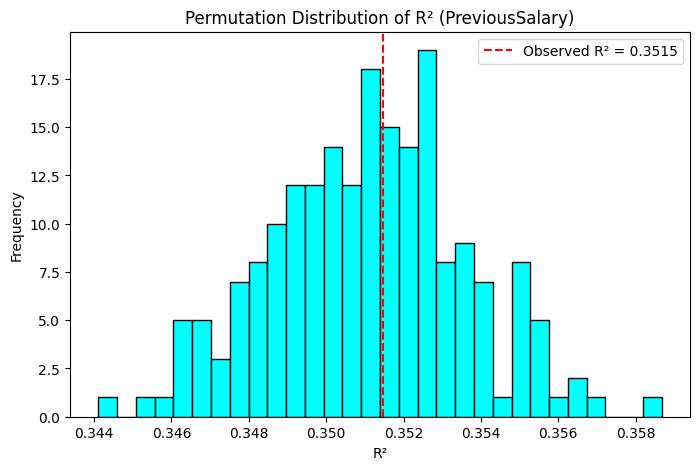

Testing additional predictive power of: Education_encoded
Observed R²: 0.3515
Permutation p-value: 0.1350
Conclusion: Fail to reject H₀. No significant additional contribution from Education_encoded detected.


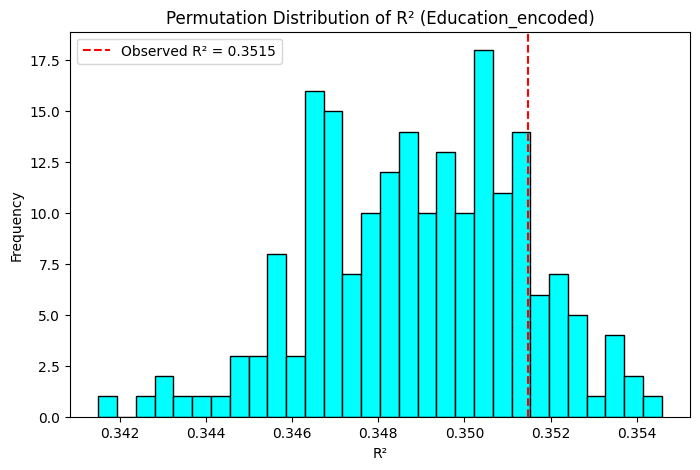

Testing additional predictive power of: ComputerSkills
Observed R²: 0.3515
Permutation p-value: 0.0000
Conclusion: Reject H₀. ComputerSkills provides significant additional predictive power for hiring outcome.


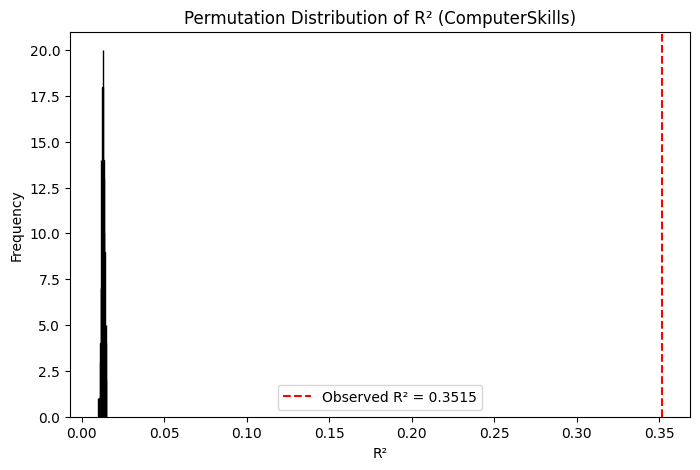

In [ ]:
# Define the list of variables to test
variables_to_test = ["YearsCodePro", "PreviousSalary", "Education_encoded", "ComputerSkills"]

# Define other features
all_features = ["YearsCodePro", "PreviousSalary", "Education_encoded", "ComputerSkills"]

# Set significance level
alpha = 0.05

# Loop over each variable
for target_var in variables_to_test:
    print("="*80)
    print(f"Testing additional predictive power of: {target_var}")

    # Step 1: Prepare data
    features = [var for var in all_features if var != target_var]
    X_full = final_df[[target_var] + features]
    X_wo_target = final_df[features]
    y = final_df['Employed']

    # Step 2: Fit reduced model (without target_var)
    model_reduced = LinearRegression()
    model_reduced.fit(X_wo_target, y)
    y_hat = model_reduced.predict(X_wo_target)
    residuals = y - y_hat

    # Step 3: Fit full model (with target_var)
    model_full = LinearRegression()
    model_full.fit(X_full, y)
    y_pred = model_full.predict(X_full)
    observed_r2 = r2_score(y, y_pred)

    # Step 4: Permutation test
    n_permutations = 200
    permuted_r2 = []

    for _ in range(n_permutations):
        shuffled_residuals = np.random.permutation(residuals)
        y_simulated = y_hat + shuffled_residuals
        model_perm = LinearRegression()
        model_perm.fit(X_full, y_simulated)
        permuted_r2.append(r2_score(y_simulated, model_perm.predict(X_full)))

    permuted_r2 = np.array(permuted_r2)
    p_value = np.mean(permuted_r2 >= observed_r2)

    # Step 5: Output results
    print(f"Observed R²: {observed_r2:.4f}")
    print(f"Permutation p-value: {p_value:.4f}")

    # Step 6: Conclusion
    if p_value < alpha:
        print(f"Conclusion: Reject H₀. {target_var} provides significant additional predictive power for hiring outcome.")
    else:
        print(f"Conclusion: Fail to reject H₀. No significant additional contribution from {target_var} detected.")

    # Step 7: Visualization
    plt.figure(figsize=(8, 5))
    plt.hist(permuted_r2, bins=30, color='cyan', edgecolor='black')
    plt.axvline(observed_r2, color='red', linestyle='--', label=f"Observed R² = {observed_r2:.4f}")
    plt.title(f'Permutation Distribution of R² ({target_var})')
    plt.xlabel('R²')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


### 4.7 The Joint Predictive Power of Experience, Salary, and Education

**Research Question:**  
Do Years of Professional Coding Experience, Previous Salary, and Education Level jointly provide significant predictive power for hiring outcome?

**Hypotheses:**
- **H₀**: The features (YearsCodePro, PreviousSalary, Education_encoded) do not jointly predict hiring outcome.
- **H₁**: The features jointly provide significant predictive power.

Based on the findings in Section 4.6, we observed that individually, `YearsCodePro`, `PreviousSalary`, and `Education_encoded` did not provide significant additional predictive power when `ComputerSkills` was already included.  
To further investigate, we now test whether these three features, **when considered together**, can jointly predict hiring outcome.

Observed R²: 0.0129
Permutation p-value: 0.0000


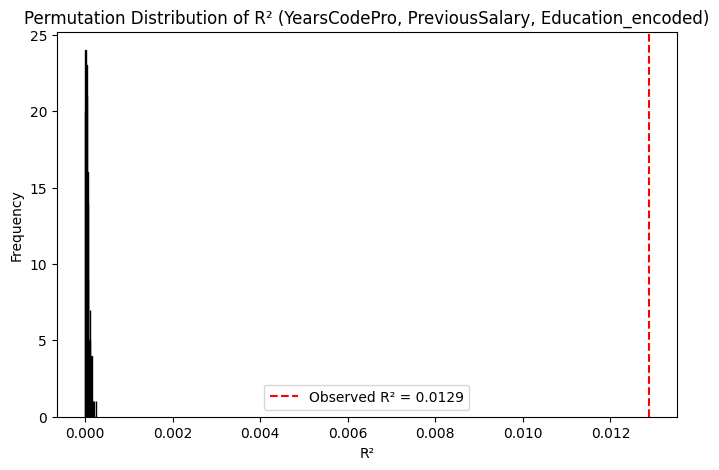

Conclusion: Reject H₀. The feature group jointly provides significant predictive power for hiring outcome.


In [ ]:
# 4.7 Testing the Joint Predictive Power of Selected Features

# Step 1: Prepare data
features = ["YearsCodePro", "PreviousSalary", "Education_encoded"]
X = final_df[features]
y = final_df['Employed']

# Step 2: Fit the true model
model_true = LinearRegression()
model_true.fit(X, y)
true_r2 = r2_score(y, model_true.predict(X))

# Step 3: Permutation test
n_permutations = 200
permuted_r2 = []

for _ in range(n_permutations):
    y_permuted = np.random.permutation(y)
    model_perm = LinearRegression()
    model_perm.fit(X, y_permuted)
    permuted_r2.append(r2_score(y_permuted, model_perm.predict(X)))

# Step 4: Calculate p-value
permuted_r2 = np.array(permuted_r2)
p_value = np.mean(permuted_r2 >= true_r2)

# Step 5: Output results
print(f"Observed R²: {true_r2:.4f}")
print(f"Permutation p-value: {p_value:.4f}")

# Step 6: Visualization
plt.figure(figsize=(8, 5))
plt.hist(permuted_r2, bins=30, color='lightgreen', edgecolor='black')
plt.axvline(true_r2, color='red', linestyle='--', label=f"Observed R² = {true_r2:.4f}")
plt.title('Permutation Distribution of R² (YearsCodePro, PreviousSalary, Education_encoded)')
plt.xlabel('R²')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Step 7: Conclusion
alpha = 0.05
if p_value < alpha:
    print("Conclusion: Reject H₀. The feature group jointly provides significant predictive power for hiring outcome.")
else:
    print("Conclusion: Fail to reject H₀. No significant joint effect found.")

### 4.8 Summary of Hypothesis Testing

In this section, we conducted a series of hypothesis tests to evaluate whether individual features or combinations of features are significantly associated with hiring outcomes. The tests include permutation testing, logistic regression, and chi-square analysis depending on the variable types.

#### Summary of Findings:

| Section | Feature(s) Tested | Method | Result |
|---------|-------------------|--------|--------|
| **4.1** | `Age` (>35 vs ≤35) | Permutation test | ✅ Significant difference in hiring outcomes between groups |
| **4.2** | `Gender_Man` (Male vs Non-male) | Permutation test | ✅ Gender is significantly associated with hiring outcome |
| **4.3** | `Education_Encoded` | Logistic regression | ✅ Education level is significantly associated with hiring outcome |
| **4.4** | `PreviousSalary` | Logistic regression | ❌ No significant association found |
| **4.5** | `MainBranch` | Chi-square test | ✅ Professional developer status  is significantly associated with hiring outcome |
| **4.6** | Individual feature contribution: | Residual-based permutation tests |  |
|         | `YearsCodePro` |  | ❌ No significant additional predictive power |
|         | `PreviousSalary` |  | ❌ No significant additional predictive power |
|         | `Education_encoded` |  | ❌ No significant additional predictive power |
|         | `ComputerSkills` |  | ✅ Adds strong predictive power  |
| **4.7** | Combined group: `YearsCodePro`, `PreviousSalary`, `Education_encoded` | Permutation test | ✅ Jointly predictive when evaluated together|


#### Interpretation & Insights

- **Demographic and categorical features** such as age group, gender, and developer identity show significant associations with hiring outcome.
- **ComputerSkills** is the most powerful individual predictor. It remains significant even when controlling for experience, salary, and education.
- In contrast, traditional indicators like **professional experience**, **previous salary**, and **education level**, while commonly assumed important, did **not** individually offer strong additional predictive power when tested in the presence of other variables.
- However, **when combined**, these three weaker individual features **do contribute meaningfully**, highlighting the potential importance of joint patterns rather than isolated factors.

---

These findings underscore the importance of **technical skill breadth** (as captured by `ComputerSkills`) in influencing hiring outcomes, possibly outweighing conventional credentials in technical domains. They also suggest that certain features may not act alone, but their **combined effect** is worth attention when designing predictive models or interpreting hiring data.


## PART 5: Modeling

**Assumption**: We are fitting this model for the Computer Science job seekers. Our model can help them to predict that whether they are likely to get the job or not, and tell them the most important feature for them to get a job.
So our first criterion is the recall score (predicted to be employed that it is real employed), because we don't want the job seekers to lose their chance. And our second criterion is accuracy to make sure that our model is accurate.

In [ ]:
def plot_confusion_matrix_plotly(y_true, y_pred, model_name="Model", color='Tealgrn'):
    cm = confusion_matrix(y_true, y_pred)
    z = cm.tolist()
    x = ['Predicted 0', 'Predicted 1']
    y = ['Actual 0', 'Actual 1']

    fig = ff.create_annotated_heatmap(
        z=z,
        x=x,
        y=y,
        colorscale=color,
        showscale=True,
        annotation_text=[[f"{val:,}" for val in row] for row in z]
    )

    fig.update_layout(
        title=f"{model_name} Confusion Matrix",
        title_x=0.5,
        xaxis_title="Predicted",
        yaxis_title="Actual",
        width=550,
        height=500
    )

    fig.show()

In [ ]:
def plot_roc_curve_plotly(y_true, y_prob, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=fpr,
        y=tpr,
        mode='lines',
        name=f'ROC Curve (AUC = {auc:.2f})',
        line=dict(color='royalblue', width=3)
    ))

    fig.add_trace(go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        name='Random Guess',
        line=dict(color='gray', dash='dash')
    ))

    fig.update_layout(
        title=f'{model_name} ROC Curve',
        title_x=0.5,
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        width=550,
        height=550,
        legend=dict(x=0.6, y=0.1),
        template='plotly_white'
    )

    fig.show()

In [ ]:
def plot_feature_importance_plotly(model, feature_names, model_name="Model", top_n=8):
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False).head(top_n)

    fig = px.bar(
        importance_df,
        x='Importance',
        y='Feature',
        orientation='h',
        title=f'Top {top_n} Feature Importances ({model_name})',
        text='Importance',
        width=1200,
        height=600
    )

    fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        title_x=0.5
    )

    fig.show()


### 5.1: Logistic Regression

#### 5.1.1: Logistic Regression with No Regulization

In [ ]:
employed = (y_train["Employed"]).mean()
employed

np.float64(0.5278770336360914)

The classes are balanced

*Advantage for Logistic Regression as Base Line:*  
**Simplicity and Interpretability**: Coefficients directly reflect the impact of each feature on the prediction, making the model highly interpretable.  
**Good Baseline for Comparison**: Serves as a clear and simple benchmark to evaluate the improvements from more complex models.  
*Limitations:*  
**Limited to Linear Relationships:** Cannot capture complex interactions between features, which may restrict predictive performance.  
**No Automatic Feature Selection:** All features are included without filtering, potentially introducing unnecessary noise.  
**Prone to Overfitting**  
**Result**:  
No Overfitting  

| Metric              | Test | Train |
|---------------------|----------|-----------|
| Accuracy            | 78.38%   | 78.52%    |
| Recall              | 79.14%   | 79.18%    |

**Important Features**(abs>1):  
ComputerSkills:                2.340963

In [ ]:
lrg = LogisticRegression(solver='lbfgs', penalty=None, random_state=42)
lrg.fit(x_train, y_train)
y_pred = lrg.predict(x_test)
y_train_pred = lrg.predict(x_train)
y_prob = lrg.predict_proba(x_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Train Precision:", precision_score(y_train, y_train_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("Train Recall   :", recall_score(y_train, y_train_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("Train F1 Score :", f1_score(y_train, y_train_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Confusion matrix for train:\n", confusion_matrix(y_train, y_train_pred))

Accuracy : 0.7837751517087193
Train Accuracy : 0.7851681804571314
Precision: 0.7974394147233653
Train Precision: 0.7993205069476256
Recall   : 0.7914082589623355
Train Recall   : 0.7918242323400393
F1 Score : 0.7944123899180079
Train F1 Score : 0.7955547112462006
Confusion matrix:
 [[4584 1329]
 [1379 5232]]
Confusion matrix for train:
 [[18394  5257]
 [ 5505 20939]]


In [ ]:
plot_confusion_matrix_plotly(y_test, y_pred, model_name="Logistic Regression (No Regularization)")

In [ ]:
plot_roc_curve_plotly(y_test, y_prob, model_name="Logistic Regression (No Regularization)")

In [ ]:
coefficients = lrg.coef_[0]
coef_series = pd.Series(coefficients, index=x_train.columns)
nonzero_coef = coef_series[coef_series != 0]
print(nonzero_coef.sort_values(key=abs, ascending=False))

ComputerSkills                2.340963
MainBranch                   -0.584933
Country_Development_Status   -0.240488
PreviousSalary               -0.197132
Employment                    0.155238
Gender_Man                    0.137852
Education_encoded            -0.122251
YearsCodePro                  0.119376
Age                           0.070770
Gender_NonBinary              0.048657
Gender_Woman                  0.048140
dtype: float64


We can see that the most important feature is the Computer Skills

#### 5.1.2: Logistic Regression with L1 Regularization

*Improvement for LR with L1*:  
**Automatic Feature Selection**: 	L1 regularization tends to shrink the coefficients of less important features to exactly zero, effectively selecting relevant features and simplifying the model.  
**Reduced Overfitting Risk**: By penalizing large coefficients, L1 regularization helps prevent the model from memorizing noise in the training data, thus improving generalization.  
*Limitations*:  
**Still Limited to Modeling Linear Relationships**: L1 regularization improves feature selection but does not enable modeling complex nonlinear interactions between features.  
**Result**:  
No Improvement in accuracy and recall

| Metric              | Test | Train  |
|---------------------|----------|-----------|
| Accuracy            | 78.23%   | 78.34%    |
| Recall              | 78.43%   | 78.29%    |

**Important Feature(abs>1)**:  
ComputerSkills:       2.222012

In [ ]:
lrg_l1 = LogisticRegression(solver='liblinear', penalty='l1', C=0.005, random_state=42)
lrg_l1.fit(x_train, y_train)
y_pred_l1 = lrg_l1.predict(x_test)
y_train_pred_l1 = lrg_l1.predict(x_train)
y_prob_l1 = lrg_l1.predict_proba(x_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred_l1))
print("Train Accuracy :", accuracy_score(y_train, y_train_pred_l1))
print("Precision:", precision_score(y_test, y_pred_l1))
print("Train Precision:", precision_score(y_train, y_train_pred_l1))
print("Recall   :", recall_score(y_test, y_pred_l1))
print("Train Recall   :", recall_score(y_train, y_train_pred_l1))
print("F1 Score :", f1_score(y_test, y_pred_l1))
print("Train F1 Score :", f1_score(y_train, y_train_pred_l1))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_l1))
print("Confusion matrix for train:\n", confusion_matrix(y_train, y_train_pred_l1))

Accuracy : 0.7823379112104759
Train Accuracy : 0.7833915560435173
Precision: 0.7995373939861218
Train Precision: 0.8020377329252703
Recall   : 0.784298895779761
Train Recall   : 0.7828997126002117
F1 Score : 0.7918448381185095
Train F1 Score : 0.7923531775647281
Confusion matrix:
 [[4613 1300]
 [1426 5185]]
Confusion matrix for train:
 [[18541  5110]
 [ 5741 20703]]


In [ ]:
plot_confusion_matrix_plotly(y_test, y_pred_l1, model_name="Logistic Regression (L1 Regularization)")

It's a basically very good model

In [ ]:
plot_roc_curve_plotly(y_test, y_prob_l1, model_name="Logistic Regression (L1 Regularization)")

In [ ]:
coefficients = lrg_l1.coef_[0]
coef_series = pd.Series(coefficients, index=x_train.columns)
nonzero_coef = coef_series[coef_series != 0]
print(nonzero_coef.sort_values(key=abs, ascending=False))

ComputerSkills       2.222012
MainBranch          -0.126133
Education_encoded   -0.099700
Employment           0.099034
YearsCodePro         0.081780
PreviousSalary      -0.079815
Gender_Man           0.050922
dtype: float64


In [ ]:
computerskills = stackoverflow_cleaned_df["ComputerSkills"].sort_values(ascending=False)
computerskills

,ComputerSkills
58911,107
44580,105
58441,101
31802,91
52902,79
...,...
58776,0
41119,0
44334,0
55837,0


**Comment**  
The Logistic Regression model is basically good, but the accuracy could be improved. Hope the Random Forest and the XGboost will perform better.  
Also, we noticed some parameters are not very reasonable. (Why a professional coder have a negative coefficient? Previous Salary and Education Level also have negative coefficients.)  
Random Forest:  
Handles both categorical and numerical features well

Robust to overfitting due to bagging

Provides clear feature importance for interpretability

Resistant to outliers and missing values  
XGBoost:  
High predictive performance with gradient boosting

Includes built-in regularization to reduce overfitting

Efficient training with parallelization

Automatically handles missing values

Flexible and tunable with many hyperparameters  
Neural Network?  
Neural networks are not ideal for this project because the data is structured(not in text or image), interpretability is important, and traditional tree-based models tend to perform better with less computational cost.


### 5.2: Random Forest

*Improvements for Random Forest*:  
**Captures Nonlinear Relationships**: Random Forest, based on decision trees, can naturally model complex feature interactions and nonlinear decision boundaries without manually creating interaction terms.  
**Reduces Overfitting**: 	By combining multiple trees trained on random subsets of the data and features (bagging), Random Forest significantly lowers overfitting risk compared to single models.  
*Limitations*:  
**Difficult in Tunning the Parameter**:Because the RF can only running on CPU, which limits the speed in tunning the parameters.  
**Result**:  

| Metric              | Test | Train  |
|---------------------|----------|-----------|
| Accuracy            | 78.43%   | 78.63%    |
| Recall              | 82.09%   | 81.94%   |

Little improvement in Accuracy. Medium improvement in Recall  
**Important Features(contribution>0.5)**:  
Computer Skills: 0.9084

**Result after tunning the hyperparameters using GridSearchCV**:  


| Metric              | Test | Train  |
|---------------------|----------|-----------|
| Accuracy            | 78.36%   | 84.00%    |
| Recall              | 82.70%   | 87.80%   |

Little risk in Overfitting  
Improvement in Test Accuracy and Recall  
**Important Feature(contribution>0.5)**:  
Computer Skills: 0.7459

**Result after tunning the hyperparameters using Bayesian optimization**:  


| Metric              | Test | Train  |
|---------------------|----------|-----------|
| Accuracy            | 78.43%   | 82.62%    |
| Recall              | 82.85%   | 86.43%   |

Little risk in Overfitting  
Improvement in Test Accuracy and Recall  
**Important Feature(contribution>0.5)**:  
Computer Skills: 0.7855

#### 5.2.1: Preliminary Model

In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=100, #num_trees
    max_depth=5, #depth of trees
    random_state=42,
    class_weight='balanced' #handle categories imbalance
)
rf_clf.fit(x_train, y_train)
y_pred_rf = rf_clf.predict(x_test)
y_train_pred_rf = rf_clf.predict(x_train)
y_prob_rf = rf_clf.predict_proba(x_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Train Accuracy :", accuracy_score(y_train, y_train_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Train Precision:", precision_score(y_train, y_train_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("Train Recall   :", recall_score(y_train, y_train_pred_rf))
print("F1 Score :", f1_score(y_test, y_pred_rf))
print("Train F1 Score :", f1_score(y_train, y_train_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Confusion matrix for train:\n", confusion_matrix(y_train, y_train_pred_rf))

Accuracy : 0.7842542318748004
Train Accuracy : 0.786306018564727
Precision: 0.7814254859611232
Train Precision: 0.785137142650096
Recall   : 0.8209045530176978
Train Recall   : 0.8194297383149297
F1 Score : 0.8006786662732369
Train F1 Score : 0.8019169920248691
Confusion matrix:
 [[4395 1518]
 [1184 5427]]
Confusion matrix for train:
 [[17721  5930]
 [ 4775 21669]]


In [ ]:
plot_confusion_matrix_plotly(y_test, y_pred_rf, model_name="Random Forest")

In [ ]:
plot_feature_importance_plotly(rf_clf, x_train.columns, model_name="Random Forest")

In [ ]:
plot_roc_curve_plotly(y_test, y_prob_rf, model_name="Random Forest")

#### 5.2.2: Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    verbose=2
)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   1.9s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   3.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=300; total time=   5.2s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=300; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=300; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=300; total time=   8.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ...class_weight=None, max_depth=5, n_estimators=300; total time=   8.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=100; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=100; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=100; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=100; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=100; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=200; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=200; total time=   7.2s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=200; total time=   6.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=200; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=200; total time=   5.8s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=300; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=300; total time=   7.9s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=300; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=300; total time=   7.8s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=10, n_estimators=300; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=100; total time=   4.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=100; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=100; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=100; total time=   3.4s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=100; total time=   4.2s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=200; total time=   6.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=200; total time=   7.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=200; total time=   6.2s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=200; total time=   7.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=200; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=300; total time=  11.5s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=300; total time=  12.8s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=300; total time=  10.8s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=300; total time=   9.8s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ..class_weight=None, max_depth=15, n_estimators=300; total time=  10.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   2.9s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   4.0s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=300; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=300; total time=   5.0s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=300; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=300; total time=   4.1s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=5, n_estimators=300; total time=   5.0s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=100; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=100; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=100; total time=   2.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=100; total time=   2.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=100; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=200; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=200; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=200; total time=   5.9s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=200; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=200; total time=   4.6s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=300; total time=   8.1s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=300; total time=   7.0s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=300; total time=   7.9s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=300; total time=   7.5s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=10, n_estimators=300; total time=   7.4s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=100; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=100; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=100; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=100; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=100; total time=   3.2s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=200; total time=   8.0s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=200; total time=  13.3s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=200; total time=   6.5s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=200; total time=   9.7s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=200; total time=   7.5s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=300; total time=  10.1s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=300; total time=  10.9s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=300; total time=  10.9s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=300; total time=  11.1s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END class_weight=balanced, max_depth=15, n_estimators=300; total time=  10.1s


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'class_weight': None, 'max_depth': 15, 'n_estimators': 100}
Best Recall Score: 0.8245348293735549


In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 80, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(clf, x_train, y_train.values.ravel(),
                            cv=5, scoring='recall', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2025-04-30 00:30:33,422] A new study created in memory with name: no-name-4eaf35d3-976d-4442-8364-1fe320e6b679
[I 2025-04-30 00:31:06,358] Trial 0 finished with value: 0.7810467533307075 and parameters: {'n_estimators': 127, 'max_depth': 25, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7810467533307075.
[I 2025-04-30 00:31:23,094] Trial 1 finished with value: 0.8143245236238028 and parameters: {'n_estimators': 161, 'max_depth': 10, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8143245236238028.
[I 2025-04-30 00:31:42,807] Trial 2 finished with value: 0.7993873835142672 and parameters: {'n_estimators': 129, 'max_depth': 19, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8143245236238028.
[I 2025-04-30 00:32:00,676] Trial 3 finished with value: 0.8240431715526386 and parameters: {'n_estimators': 177, 'max_depth': 11, 'class_weight': None}. Best is trial 3 with value: 0.8240431715526386.
[I 2025-04-30 00:32:23,898] Trial 4 finished with value: 0.7

In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best recall score:", study.best_value)

Best hyperparameters: {'n_estimators': 140, 'max_depth': 14, 'class_weight': None}
Best recall score: 0.8271441255206978


In [ ]:
rf_clf_revised = RandomForestClassifier(
    n_estimators=100, #num_trees
    max_depth=15, #depth of trees
    random_state=42,
    class_weight=None #handle categories imbalance
)
rf_clf_revised.fit(x_train, y_train)
y_pred_rf_revised = rf_clf_revised.predict(x_test)
y_train_pred_rf_revised = rf_clf_revised.predict(x_train)
y_prob_rf_revised = rf_clf_revised.predict_proba(x_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred_rf_revised))
print("Train Accuracy :", accuracy_score(y_train, y_train_pred_rf_revised))
print("Precision:", precision_score(y_test, y_pred_rf_revised))
print("Train Precision:", precision_score(y_train, y_train_pred_rf_revised))
print("Recall   :", recall_score(y_test, y_pred_rf_revised))
print("Train Recall   :", recall_score(y_train, y_train_pred_rf_revised))
print("F1 Score :", f1_score(y_test, y_pred_rf_revised))
print("Train F1 Score :", f1_score(y_train, y_train_pred_rf_revised))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf_revised))
print("Confusion matrix for train:\n", confusion_matrix(y_train, y_train_pred_rf_revised))

Accuracy : 0.7836154583200255
Train Accuracy : 0.8400239544864757
Precision: 0.7773354187402246
Train Precision: 0.8290131391031134
Recall   : 0.826955074875208
Train Recall   : 0.8780441688095598
F1 Score : 0.8013778950454412
Train F1 Score : 0.8528245059869243
Confusion matrix:
 [[4347 1566]
 [1144 5467]]
Confusion matrix for train:
 [[18862  4789]
 [ 3225 23219]]


In [ ]:
rf_clf_BO = RandomForestClassifier(
    n_estimators=140, #num_trees
    max_depth=14, #depth of trees
    random_state=42,
    class_weight=None #handle categories imbalance
)
rf_clf_BO.fit(x_train, y_train)
y_pred_rf_BO = rf_clf_BO.predict(x_test)
y_train_pred_rf_BO = rf_clf_BO.predict(x_train)
y_prob_rf_BO = rf_clf_BO.predict_proba(x_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred_rf_BO))
print("Train Accuracy :", accuracy_score(y_train, y_train_pred_rf_BO))
print("Precision:", precision_score(y_test, y_pred_rf_BO))
print("Train Precision:", precision_score(y_train, y_train_pred_rf_BO))
print("Recall   :", recall_score(y_test, y_pred_rf_BO))
print("Train Recall   :", recall_score(y_train, y_train_pred_rf_BO))
print("F1 Score :", f1_score(y_test, y_pred_rf_BO))
print("Train F1 Score :", f1_score(y_train, y_train_pred_rf_BO))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf_BO))
print("Confusion matrix for train:\n", confusion_matrix(y_train, y_train_pred_rf_BO))

Accuracy : 0.7843340785691473
Train Accuracy : 0.8261902385467611
Precision: 0.7775411697898921
Train Precision: 0.8170151921358356
Recall   : 0.8284677053395856
Train Recall   : 0.8643170473453335
F1 Score : 0.8021969974368364
Train F1 Score : 0.840000735037395
Confusion matrix:
 [[4346 1567]
 [1134 5477]]
Confusion matrix for train:
 [[18532  5119]
 [ 3588 22856]]


In [ ]:
plot_confusion_matrix_plotly(y_test, y_pred_rf_revised, model_name="Random Forest (GridSearchCV)")

In [ ]:
plot_confusion_matrix_plotly(y_test, y_pred_rf_BO, model_name="Random Forest (Bayesian Optimization)")

In [ ]:
plot_feature_importance_plotly(rf_clf_revised, x_train.columns, model_name="Random Forest (GridSearchCV)")

In [ ]:
plot_feature_importance_plotly(rf_clf_BO, x_train.columns, model_name="Random Forest (Bayesian Optimization)")

In [ ]:
plot_roc_curve_plotly(y_test, y_prob_rf_revised, model_name="Random Forest (GridSearchCV)")

In [ ]:
plot_roc_curve_plotly(y_test, y_prob_rf_BO, model_name="Random Forest (Bayesian Optimization)")

#### Summary of GridSearchCV vs Bayesian Optimization

####  GridSearchCV Configuration

We performed an exhaustive grid search with the following parameter grid:

- `n_estimators`: [100, 200, 300]  
- `max_depth`: [5, 10, 15]  
- `class_weight`: [None, 'balanced']

**Best parameters found**:  
- `n_estimators = 100`  
- `max_depth = 15`  
- `class_weight = 'None'`

Notably, both `n_estimators = 100` and `max_depth = 15` lie on the **edges** of the search grid.  
This raises a concern: if model performance continues improving near the boundaries, the true optimum may lie **outside the grid**.  
Since GridSearchCV evaluates only a limited discrete set of values, it may **miss better combinations** unless the grid is finely tuned — which is often computationally expensive.

---

#### Bayesian Optimization with Optuna

To address this limitation, we applied **Bayesian Optimization** using Optuna. Unlike GridSearchCV, Bayesian Optimization searches the hyperparameter space **more efficiently and continuously**.

**Search Space**:  
- `n_estimators`: 80 to 200 (integer)  
- `max_depth`: 10 to 30 (integer)  
- `class_weight`: [None, 'balanced']

This search range **includes the best values from GridSearchCV**, ensuring comparability.

**Best parameters found after 40 trials**:  
- `n_estimators = 140`  
- `max_depth = 14`  
- `class_weight = 'None'`

The optimal values lie **between** the grid points used in GridSearchCV, suggesting that model performance was still improving near the GridSearch boundaries and that Bayesian Optimization successfully located a better solution.

---

###  Summary of Tuning Results

| Tuning Method           | n_estimators | max_depth | class_weight | Note                                |
|-------------------------|--------------|-----------|---------------|-------------------------------------|
| GridSearchCV            | 100          | 15        | balanced      | Boundary values in coarse grid      |
| Bayesian Optimization   | 140          | 14        | balanced      | Found better values between grid points |

---

###  Conclusion

Bayesian Optimization provided a more effective hyperparameter search strategy than GridSearchCV:

- Explored a **continuous** parameter space  
- Required **fewer evaluations**  
- Found **better-performing hyperparameters**  
- Especially effective when informed by prior GridSearch results: by observing that the best values lay on the **grid boundaries**, we expanded and refined the search range for Bayesian Optimization.


### 5.3: XGBoost

*Improvements in XGBoost*:  
**Better Handling of Complex Feature Interactions**: It can automatically model intricate high-order feature combinations, capturing subtle patterns that Random Forest might miss.  
**Faster Training with GPU Acceleration**: XGBoost can leverage GPU resources for faster training and tuning, making it much more efficient and suitable for finer, more detailed hyperparameter optimization.  
**Result**:  

| Metric              | Test Set | Train Set |
|---------------------|----------|-----------|
| Accuracy            | 78.56%   | 79.53%    |
| Recall              | 82.68%   | 83.43%    |

Little improvement in Accuracy  
No risk in Overfitting  
**Important Feature(contribution>0.5)**:  
Computer Skills: 0.7934  
**Result after Tunning the Hyperparameter**:  


| Metric              | Test Set | Train Set |
|---------------------|----------|-----------|
| Accuracy            | 78.26%   | 79.82%    |
| Recall              | 86.84%   | 88.03%    |

Huge improvement in Recall  
**Important Feature(contribution>0.5)**:  
Computer Skills: 0.9342

#### 5.3.1: Preliminary Model

In [ ]:
xgb_clf = XGBClassifier(
    tree_method='hist',      # Using GPU
    device='cuda',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',       # Avoid Warning
    random_state=42
)

xgb_clf.fit(x_train, y_train)
y_pred_xgb = xgb_clf.predict(x_test)
y_train_pred_xgb = xgb_clf.predict(x_train)
y_prob_xgb = xgb_clf.predict_proba(x_test)[:, 1]  # Ploting ROC AUC
threshold = 0.4
y_pred_thresh = (y_prob_xgb >= threshold).astype(int)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[23:41:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Train Accuracy :", accuracy_score(y_train, y_train_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Train Precision:", precision_score(y_train, y_train_pred_xgb))
print("Recall   :", recall_score(y_test, y_pred_xgb))
print("Train Recall   :", recall_score(y_train, y_train_pred_xgb))
print("F1 Score :", f1_score(y_test, y_pred_xgb))
print("Train F1 Score :", f1_score(y_train, y_train_pred_xgb))
# print("Recall at threshold 0.4:", recall_score(y_test, y_pred_thresh))
# print("Precision at threshold 0.4:", precision_score(y_test, y_pred_thresh))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Confusion matrix for train:\n", confusion_matrix(y_train, y_train_pred_xgb))

Accuracy : 0.7856116256786969
Train Accuracy : 0.7951891406327977
Precision: 0.780188409934342
Train Precision: 0.7896206156048676
Recall   : 0.8268038118287703
Train Recall   : 0.8342913326274392
F1 Score : 0.8028200044062569
Train F1 Score : 0.8113415710503089
Confusion matrix:
 [[4373 1540]
 [1145 5466]]
Confusion matrix for train:
 [[17773  5878]
 [ 4382 22062]]


In [ ]:
plot_confusion_matrix_plotly(y_test, y_pred_xgb, model_name="XGBoost")

In [ ]:
plot_feature_importance_plotly(xgb_clf, x_train.columns, model_name="XGBoost")

In [ ]:
plot_roc_curve_plotly(y_test, y_prob_xgb, model_name="XGBoost")

#### 5.3.2: Hyperparameter Tuning  

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200], #num_trees
    'max_depth': [4, 6, 8, 10], #depth of trees
    'learning_rate': [0.1, 0.05, 0.03, 0.01], #learning rate
}

In [ ]:
xgb = XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    eval_metric='logloss',
    subsample = 0.8,
    colsample_bytree = 0.8
)

scorer = make_scorer(recall_score)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=2
)
grid_search.fit(x_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best recall score (CV average):", grid_search.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.2s
[CV] END ....learning_rate=0.1, max_depth=4, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=150; total time=   0.6s
[CV] END ...learning_rate=0.1, max_depth=4, n_e

In [ ]:
xgb_clf_revised = XGBClassifier(
    tree_method='hist',      # Using GPU
    device='cuda',
    n_estimators=50,
    max_depth=10,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',       # Avoid Warning
    random_state=42
)

xgb_clf_revised.fit(x_train, y_train)
y_pred_xgb_revised = xgb_clf_revised.predict(x_test)
y_train_pred_xgb_revised = xgb_clf_revised.predict(x_train)
y_prob_xgb_revised = xgb_clf_revised.predict_proba(x_test)[:, 1]  # Ploting ROC AUC
threshold = 0.4
y_pred_thresh_revised = (y_prob_xgb_revised >= threshold).astype(int)

In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred_xgb_revised))
print("Train Accuracy :", accuracy_score(y_train, y_train_pred_xgb_revised))
print("Precision:", precision_score(y_test, y_pred_xgb_revised))
print("Train Precision:", precision_score(y_train, y_train_pred_xgb_revised))
print("Recall   :", recall_score(y_test, y_pred_xgb_revised))
print("Train Recall   :", recall_score(y_train, y_train_pred_xgb_revised))
print("F1 Score :", f1_score(y_test, y_pred_xgb_revised))
print("Train F1 Score :", f1_score(y_train, y_train_pred_xgb_revised))
print("Recall at threshold 0.4:", recall_score(y_test, y_pred_thresh_revised))
print("Precision at threshold 0.4:", precision_score(y_test, y_pred_thresh_revised))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_xgb_revised))
print("Confusion matrix for train:\n", confusion_matrix(y_train, y_train_pred_xgb_revised))

Accuracy : 0.7825774512935164
Train Accuracy : 0.7982233755863859
Precision: 0.7559915722939162
Train Precision: 0.770284579748511
Recall   : 0.8684011495991529
Train Recall   : 0.8802752987445167
F1 Score : 0.8083069341781063
Train F1 Score : 0.8216151348298744
Recall at threshold 0.4: 0.9854787475419755
Precision at threshold 0.4: 0.6361062292520993
Confusion matrix:
 [[4060 1853]
 [ 870 5741]]
Confusion matrix for train:
 [[16709  6942]
 [ 3166 23278]]


In [ ]:
plot_confusion_matrix_plotly(y_test, y_pred_xgb_revised, model_name="XGBoost (Tuned)")

In [ ]:
plot_feature_importance_plotly(xgb_clf_revised, x_train.columns, model_name="XGBoost (Tuned)")

In [ ]:
plot_roc_curve_plotly(y_test, y_prob_xgb_revised, model_name="XGBoost (Tuned)")

### 5.4: Neural Network

Although Neural Networks is not suitable for Tabulate Data, but we decided to try on this method to see the accuracy and recall and compare it with other models. Also, we can extract the importance for features with “shap” method.

**Result**:   


| Metric              | Test Set | Train Set |
|---------------------|----------|-----------|
| Accuracy            | 79%   | 79%    |
| Recall              | 83%   | 83%    |

No Improvement in Accuracy and Recall  
**Important Feature(Importance>0.1)**:  
Computer Skills: 0.28  
This result shows that NN doesn't improve much, which indicates that NN is not suitable for Tabulate and Predictive Data.

#### 5.4.1: Model Implementation

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=256,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7538 - loss: 0.5110 - recall: 0.7962 - val_accuracy: 0.7871 - val_loss: 0.4378 - val_recall: 0.7667
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7867 - loss: 0.4394 - recall: 0.8102 - val_accuracy: 0.7875 - val_loss: 0.4366 - val_recall: 0.7867
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7850 - loss: 0.4400 - recall: 0.8214 - val_accuracy: 0.7884 - val_loss: 0.4322 - val_recall: 0.8297
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7868 - loss: 0.4376 - recall: 0.8301 - val_accuracy: 0.7900 - val_loss: 0.4316 - val_recall: 0.8375
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7886 - loss: 0.4382 - recall: 0.8252 - val_accuracy: 0.7879 - val_loss: 0.4352 - val_recall: 0.7829
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7904 - loss: 0.4361 - recall: 0.8286 - val_accuracy: 0.7889 - val_loss: 0.4322 - val_recall: 0.8135
Epo

In [ ]:
y_prob_nn = model.predict(x_test).flatten()
y_prob_train_nn = model.predict(x_train).flatten()
y_pred_nn = (y_prob_nn >= 0.5).astype(int)
y_pred_train_nn = (y_prob_train_nn >= 0.5).astype(int)

print(classification_report(y_test, y_pred_nn))
print(classification_report(y_train, y_pred_train_nn))
print(confusion_matrix(y_test, y_pred_nn))
print(confusion_matrix(y_train, y_pred_train_nn))

392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.74      0.77      5913
           1       0.78      0.83      0.80      6611

    accuracy                           0.79     12524
   macro avg       0.79      0.78      0.78     12524
weighted avg       0.79      0.79      0.79     12524

              precision    recall  f1-score   support

           0       0.80      0.75      0.77     23651
           1       0.78      0.83      0.81     26444

    accuracy                           0.79     50095
   macro avg       0.79      0.79      0.79     50095
weighted avg       0.79      0.79      0.79     50095

[[4375 1538]
 [1140 5471]]
[[17645  6006]
 [ 4518 21926]]


#### 5.4.2: Extract the Feature Importance

PermutationExplainer explainer: 101it [00:16,  3.34it/s]


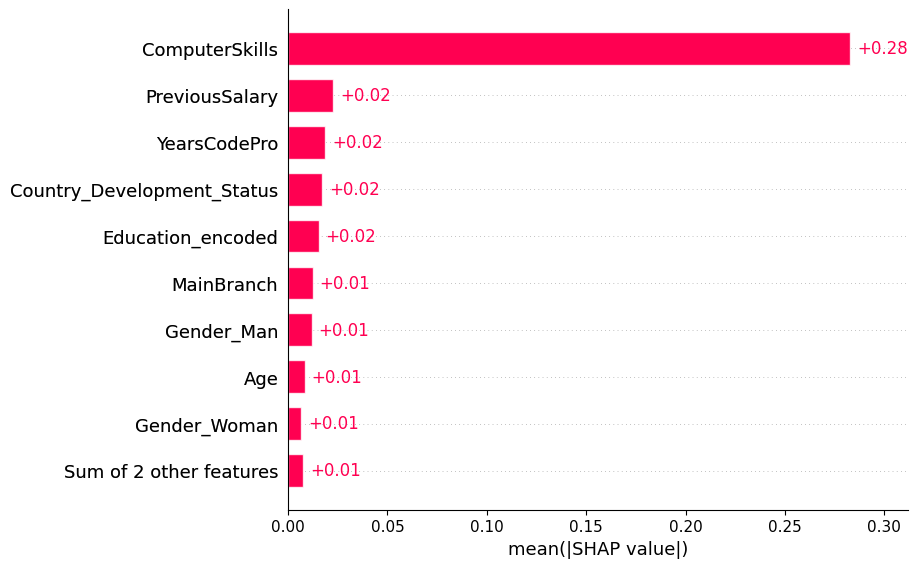

In [ ]:
explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_test[:100])
shap.plots.bar(shap_values)

### 5.5: K-Nearest Neighbors

The K-Nearest Neighbors (KNN) classifier was trained and evaluated on the test set after hyperparameter tuning via RandomizedSearchCV. Below is a detailed breakdown of its performance.

#### Overall Accuracy  
The classifier achieved an accuracy of **78.33%**, indicating that it correctly predicted approximately 78% of the test samples.

#### Classification Performance  
- **Class 0** (Negative Class):  
  - **Precision**: 78.51% — Among all predictions labeled as Class 0, 78.51% were correct.  
  - **Recall**: 74.50% — The model correctly identified 74.50% of actual Class 0 instances.  
  - **F1-Score**: 76.45% — Reflects the balance between precision and recall for this class.

- **Class 1** (Positive Class):  
  - **Precision**: 78.19% — The model correctly labeled 78.19% of predicted Class 1 samples.  
  - **Recall**: 81.76% — Indicates strong sensitivity in detecting actual Class 1 outcomes.  
  - **F1-Score**: 79.93% — Demonstrates solid performance in identifying positive cases.

- **Macro-Averaged Metrics**:  
  Precision, recall, and F1-score are approximately 78.35%, 78.13%, and 78.19%, indicating balanced performance across both classes.

- **Weighted Averages**:  
  The model achieved a weighted precision of 78.34%, recall of 78.33%, and F1-score of 78.29%, considering class imbalance.

#### Confusion Matrix  
|                | Predicted Class 0 | Predicted Class 1 |
|----------------|-------------------|-------------------|
| **True Class 0** | 4,405              | 1,508              |
| **True Class 1** | 1,206              | 5,405              |

- The classifier shows stronger recall and F1-score for Class 1, suggesting it is particularly effective at capturing positive instances.  
- Misclassifications are moderately balanced, with some room for improvement in identifying Class 0 cases.

#### ROC Curve Analysis  
- The model achieves a strong **AUC score of 0.87**, indicating excellent separability between classes across thresholds.  
- The ROC curve confirms the model’s reliable performance for binary classification.

#### Final Remarks  
- This performance was obtained using randomized search with cross-validation, confirming that a high `k` value (49) with the Manhattan distance metric and uniform weights yielded optimal results.  
- The model maintains solid, balanced results and demonstrates particular effectiveness in identifying positive class cases, which may be valuable in applications sensitive to false negatives.


#### 5.5.1: Hyperparameter Tuning  

In [ ]:
param_dist = {
    'n_neighbors': [33, 37, 41, 45, 49],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    n_iter=14,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(x_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=14, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': [33, 37, 41, 45, 49],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

Best Parameters: {'weights': 'uniform', 'n_neighbors': 49, 'metric': 'manhattan'}
Best Cross-Validated Accuracy: 0.782313604152111


#### 5.5.2: Model Fitting

In [ ]:
knn_RS = KNeighborsClassifier(n_neighbors=49, weights='uniform', metric='manhattan')
knn_RS.fit(x_train, y_train)

y_pred_knn_RS = knn_RS.predict(x_test)
y_prob_knn_RS = knn_RS.predict_proba(x_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_knn_RS)
print(f"KNN Accuracy: {accuracy:.4f}")

report = classification_report(y_test, y_pred_knn_RS, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("\nClassification Report:")
print(report_df)

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



KNN Accuracy: 0.7833

Classification Report:
              precision    recall  f1-score       support
0              0.785065  0.744969  0.764491   5913.000000
1              0.781860  0.817577  0.799320   6611.000000
accuracy       0.783296  0.783296  0.783296      0.783296
macro avg      0.783463  0.781273  0.781906  12524.000000
weighted avg   0.783373  0.783296  0.782876  12524.000000


In [ ]:
plot_confusion_matrix_plotly(y_test, y_pred_knn_RS, model_name="KNN (RandomizedSearchCV)")

In [ ]:
plot_roc_curve_plotly(y_test, y_prob_knn_RS, model_name="KNN (RandomizedSearchCV)")

## PART 6: Summary

**Main Takeaways**

1. **Computer Skills consistently demonstrated strong predictive power** in models that support feature importance analysis, which was also validated through hypothesis testing.


2. **Conventional features** such as `PreviousSalary`, `YearsCodePro`, and `Education_encoded` showed **limited individual predictive power** when tested alongside Computer Skills. However, these features did demonstrate **significant joint predictive value**, emphasizing the importance of modeling interactions.

3. **Statistical hypothesis testing** confirmed that several demographic features—such as **age group**, **gender**, and **developer status**—were significantly associated with hiring outcome. These associations provide meaningful insights into real-world hiring dynamics.

4. **The XGBoost model with tunning the hyperparameters achieved the highest test recall (86.8%)**, we finally decide to use the XGBoost model after tunning the hyperparameters, which kept a high accuracy and achieved a higher Recall score.



5. **Bayesian Optimization using Optuna** was used to fine-tune hyperparameters after an initial GridSearchCV. GridSearch helped us identify a **reasonable parameter range**, while Bayesian Optimization further **refined the search within that range**. This two-step approach allowed us to balance **broad exploration** with **efficient convergence**, ultimately identifying better-performing hyperparameters with fewer evaluations.

**Potential Future Improvements**

1. Incorporate additional external datasets (e.g., company profiles, job market trends) to enrich the feature space and further improve model generalization.

2. Apply **NLP techniques** to textual fields (such as open-ended survey responses) that were excluded, potentially unlocking new predictive signals.

**Team Reflection**

- We encountered key challenges such as encoding the high-cardinality **Country** feature and the **parameter tuning** for Random Forest, both of which deepened our understanding of the practical and iterative nature of machine learning workflows.

- We learned that **simpler models such as KNN** can still deliver strong performance when properly tuned, even compared to more complex models. This highlights that higher model complexity doesn't always lead to better results, and empirical evaluation remains essential.

- Overall, this was a rewarding and practical opportunity to apply theory to a real-world dataset and draw meaningful insights for both job seekers and recruiters.
